## 深度学习的基本流程
### 1. 模型
模型只负责正向传播`forward`
### 2. 损失函数`Loss Function`
负责发起反向传播
### 3.训练流程
1. 从训练集中取**一批**`batch`样本
2. 把样本`x`送入模型`model`，得到结果`y_pred`
3. 通过损失函数，反向传播，计算每个参数的$(w, b)$梯度
4. 利用优化器，通过梯度下降法，更新参数
5. 利用优化器，清空参数的梯度
6. 重复1-5，直到迭代结束（各项指标满足要求或误差很小）
### 4.推理流程
1. 拿到待测样本X（推理时只有特征，没有标签）
2. 把样本特征X送入模型，得到预测结果`y_pred`
3. 根据`y_pred`解析并反馈预测结果


### callback/invoke/回调函数
* 由用户定义，由系统调用
* 定一个函数，挂到一个地方，系统在合适的时机来调用它
一般来说回调函数都不应该由用户主动调用
例如 `__init__`,当在初始化一个class时，用户调用

## 深度学习的项目流程
1. 使用生成器来批量化打包数据，
    * 生成器记录了一个规则，调用一次返回一部分数据
    * 分两步走，先定义dataset，再定义dataloader
2. 构建模型
    * sequential 顺序模型
    * class 定义模型
3. 定义损失函数和优化器
    * 损失函数：MSE或CE
    * 优化器 SGD，adam
4. 训练模型
    * 训练过程中需要监控指标，如：准确率，损失值等
    * 训练过程中需要保存模型参数，方便后续推理
    * 避免出现过拟合
5. 推理模型
## 利用深度学习实现线性回归
使用房价预测案例

In [1]:
from typing import Sequence

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


#数据读取
data_df = pd.read_csv("house_data.csv")
data = data_df.to_numpy()
X = data[:, :-1]
y = data[:, -1]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 数据预处理，如果不预处理就会梯度爆炸，这里用标准化预处理数据

_mean = X_train.mean(axis=0)
_std = X_train.std(axis=0) + 1e-9
X_train = (X_train - _mean) / _std
X_test = (X_test - _mean) / _std


# 数据打包
#自定义一个数据集类
class MyDataset(Dataset):
    '''
    自定义一个房价Dataset
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        '''
        :return: counts of samples in dataset
        '''
        return len(self.X)
    def __getitem__(self, idx):
        '''
        :param idx:
        :return: tensor of samples in dataset
        '''
        return torch.tensor(data=self.X[idx], dtype=torch.float32), torch.tensor(data=[self.y[idx]], dtype=torch.float32)

#训练集加载器
house_train_dataset = MyDataset(X_train, y_train)
house_train_dataloader = DataLoader(house_train_dataset, batch_size=12, shuffle=True)

#测试集加载器
house_test_dataset = MyDataset(X_test, y_test)
house_test_dataloader = DataLoader(house_test_dataset, batch_size=32, shuffle=False)

In [2]:
## 构建模型
from torch import nn

'''
方法一：
model = nn.Linear(in_features=13, out_features=1)
方法二：
model = nn.Sequential(nn.Linear(in_features=13, out_features=1),)
'''

# 方法三，更通用
class Model(nn.Module):
    def __init__(self, n_features=13):
        '''
        接收超参
        定义处理的层
        '''
        #先初始化父类
        super(Model, self).__init__()
        # 定义一个线性层（做一次矩阵变换）
        self.linear1 = nn.Linear(in_features=n_features, out_features=8)
        self.linear2 = nn.Linear(in_features=8, out_features=1)

    def forward(self, x):
        '''
        模型的正向传播逻辑
        '''
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x

model = Model(n_features=13)

In [3]:
def get_loss(dataloader):
    # 模型设置为评估模式（batch Norm、，LayerNorm，Dropout层在train模式和evel模式下行为不同）
    model.eval()
    # 收集每个batch的loss
    losses = []
    # 构建一个无梯度的环境，底层不会自动构建一个自动图，节约资源
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            loss = nn.MSELoss()(y_pred, y)
            losses.append(loss.item())
        # 计算每个批量损失的平均值
        final_loss = round(sum(losses) / len(losses),ndigits=5)
    return final_loss

In [12]:
# 训练模型

epochs = 50 #定义训练的轮次
learning_rate = 1e-2 #学习率
loss_fn = nn.MSELoss() #定义损失函数
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate) #定义优化器

#开始训练过程
def train():
    # 记录训练过程
    train_losses = []
    test_losses = []
    #轮次循环
    for epoch in range(epochs):
        model.train()
        # 每个批量
        for X, y in house_train_dataloader:
            #开始正向传播
            y_pred = model(X)
            #误差计算
            loss = loss_fn(y_pred, y)
            # 反向传播
            loss.backward()
            #优化一步
            optimizer.step()
            #清空梯度
            optimizer.zero_grad()
            # # 打印当前批量损失，防止梯度爆炸
            # print(loss)
        train_loss = get_loss(house_train_dataloader)
        test_loss = get_loss(house_test_dataloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return train_losses, test_losses

In [13]:
train_losses, test_losses = train()

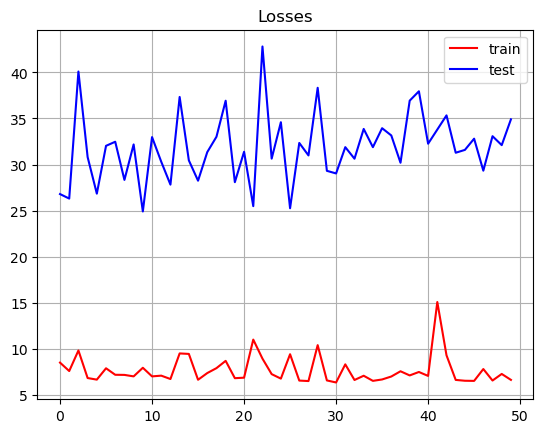

In [14]:
# 结果绘制
from matplotlib import pyplot as plt

plt.plot(train_losses,label='train',color='r')
plt.plot(test_losses,label='test',color='b')
plt.title('Losses')
plt.legend()
plt.grid(True)

In [7]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor()

reg.fit(X=X_train, y=y_train)

DecisionTreeRegressor()

In [9]:
y_pred = reg.predict(X=X_test)

In [10]:
((y_pred - y_test) **2).mean()

9.642450980392157

In [11]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X=X_train, y=y_train)
y_pred = reg.predict(X=X_test)
((y_pred - y_test) **2).mean()

24.29111947497351